<a href="https://colab.research.google.com/github/RaphaelUCL/Raphael_Medioni/blob/main/Portfolio_Optimisation_with_Markowitz_Efficient_Frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Introduction

This notebook demonstrates how to apply Markowitz's Modern Portfolio Theory (MPT) using real stock price data collected via `yfinance`.

We will:
- Calculate daily returns for a selection of stocks
- Simulate thousands of random portfolios to create the Efficient Frontier
- Identify optimal portfolios using different strategies:
  - Maximise the Sharpe Ratio
  - Minimise portfolio volatility
  - Achieve a specific target return
- Visualise all results to understand the trade-off between risk and return


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime, timedelta


In [2]:
def get_stock_data(tickers, period='3y'):
    """
    Download historical adjusted close prices using yfinance.

    Parameters:
    - tickers (list): List of stock ticker symbols (e.g. ['AAPL', 'MSFT'])
    - period (str): Time period to retrieve (e.g. '1y', '3y', '5y')

    Returns:
    - DataFrame: Closing prices with tickers as columns and dates as index
    """
    stock_data = yf.download(tickers, period=period)['Close']
    return stock_data.dropna()

## Compute daily returns

We calculate the daily percentage returns using the `pct_change()` method from pandas.

Returns are required to compute key portfolio metrics such as expected return, volatility (standard deviation), and the Sharpe ratio. We remove the first row, which contains missing values.



In [3]:
def compute_daily_returns(price_df):
    """
    Compute daily percentage returns from price data.

    Parameters:
    - price_df (DataFrame): Stock price data with tickers as columns

    Returns:
    - DataFrame: Daily returns
    """
    returns = price_df.pct_change().dropna()
    return returns

## Calculate portfolio performance

We compute the expected annual return, annualised volatility, and Sharpe ratio of a portfolio based on historical daily returns and a set of asset weights.

The Sharpe ratio is calculated assuming a risk-free rate of 0.


In [4]:
def calculate_portfolio_performance(weights, returns_df):
    """
    Calculate expected return, volatility, and Sharpe ratio of a portfolio.

    Parameters:
    - weights (array): Portfolio asset weights (must sum to 1)
    - returns_df (DataFrame): Daily asset returns

    Returns:
    - tuple: (annual return, annual volatility, Sharpe ratio)
    """
    weights = np.array(weights)
    mean_returns = returns_df.mean() * 252
    cov_matrix = returns_df.cov() * 252

    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility != 0 else 0.0

    return portfolio_return, portfolio_volatility, sharpe_ratio

## Optimise portfolio allocation

We use `scipy.optimize.minimize()` to determine the optimal asset weights based on three possible objectives:

- Maximise the Sharpe Ratio
- Minimise portfolio volatility
- Minimise risk while targeting a specific expected return

The optimisation is subject to realistic constraints: all weights are between 0 and 1 (long-only), and their sum equals 1.


In [5]:
def optimise_portfolio(returns, optimisation_type='sharpe', target_return=None):
    """
    Optimise a portfolio allocation based on a selected objective.

    Parameters:
    - returns (DataFrame): Daily asset returns
    - optimisation_type (str): One of 'sharpe', 'min_volatility', or 'target_return'
    - target_return (float): Required only if optimisation_type is 'target_return'

    Returns:
    - tuple: (optimal weights, portfolio performance metrics)
    """
    num_assets = len(returns.columns)
    initial_guess = np.ones(num_assets) / num_assets
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    def negative_sharpe(weights):
        return -calculate_portfolio_performance(weights, returns)[2]

    def min_volatility(weights):
        return calculate_portfolio_performance(weights, returns)[1]

    if optimisation_type == 'sharpe':
        objective = negative_sharpe
    elif optimisation_type == 'min_volatility':
        objective = min_volatility
    elif optimisation_type == 'target_return' and target_return is not None:
        constraints.append({'type': 'eq', 'fun': lambda x: calculate_portfolio_performance(x, returns)[0] - target_return})
        objective = min_volatility
    else:
        raise ValueError("Invalid optimisation type or missing target return.")

    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        raise RuntimeError("Optimisation did not converge.")

    optimal_weights = result.x
    performance = calculate_portfolio_performance(optimal_weights, returns)

    return optimal_weights, performance


## Simulate portfolios and generate the efficient frontier

We generate thousands of random portfolios by assigning different combinations of asset weights.

For each portfolio, we calculate the expected return, volatility, and Sharpe ratio. These values are used to build the efficient frontier, which represents all possible risk-return combinations for the given assets.


In [6]:
def generate_efficient_frontier(returns, num_portfolios=5000):
    """
    Simulate random portfolios to generate the efficient frontier.

    Parameters:
    - returns (DataFrame): Daily asset returns
    - num_portfolios (int): Number of portfolios to simulate

    Returns:
    - DataFrame: Portfolio statistics and weights
    """
    num_assets = len(returns.columns)
    all_weights = np.zeros((num_portfolios, num_assets))
    return_array = np.zeros(num_portfolios)
    volatility_array = np.zeros(num_portfolios)
    sharpe_array = np.zeros(num_portfolios)

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        all_weights[i, :] = weights

        r, vol, sr = calculate_portfolio_performance(weights, returns)
        return_array[i] = r
        volatility_array[i] = vol
        sharpe_array[i] = sr

    portfolio_data = {
        'Return': return_array,
        'Volatility': volatility_array,
        'Sharpe Ratio': sharpe_array
    }

    for i, ticker in enumerate(returns.columns):
        portfolio_data[f'Weight_{ticker}'] = all_weights[:, i]

    return pd.DataFrame(portfolio_data)



## Visualise the efficient frontier

We display all simulated portfolios in a risk-return space, where each point represents a portfolio with a specific return and volatility.

Portfolios are colour-coded by their Sharpe ratio. If available, we also highlight the optimal portfolios, such as the maximum Sharpe ratio portfolio or the minimum volatility portfolio.


In [7]:
def plot_efficient_frontier(portfolios_df, optimal_portfolios=None):
    """
    Plot the efficient frontier with optional optimal portfolios.

    Parameters:
    - portfolios_df (DataFrame): Contains return, volatility, Sharpe ratio, and weights
    - optimal_portfolios (dict): Optional dictionary of (weights, performance) tuples
    """
    plt.figure(figsize=(12, 8))

    plt.scatter(
        portfolios_df['Volatility'],
        portfolios_df['Return'],
        c=portfolios_df['Sharpe Ratio'],
        cmap='viridis',
        alpha=0.4,
        s=10
    )

    if optimal_portfolios:
        markers = ['*', 'P', 'X', 'D']
        colours = ['r', 'g', 'b', 'orange']

        for i, (name, (_, perf)) in enumerate(optimal_portfolios.items()):
            plt.scatter(
                perf[1], perf[0],
                color=colours[i % len(colours)],
                marker=markers[i % len(markers)],
                s=200,
                label=name
            )

    plt.title('Efficient Frontier with Optimal Portfolios')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Run the full portfolio analysis

This function brings together all components of the simulation and optimisation process.

It:
- Downloads price data
- Computes daily returns
- Simulates random portfolios to build the efficient frontier
- Finds optimal portfolios based on different strategies (maximum Sharpe, minimum volatility, and target


In [8]:
def analyse_portfolio(tickers, period='3y', num_portfolios=5000, target_return_levels=[0.25, 0.5, 0.75]):
    """
    Run a complete portfolio optimisation analysis.

    Parameters:
    - tickers (list): List of stock ticker symbols (e.g. ['AAPL', 'MSFT'])
    - period (str): Time period for historical data (e.g. '3y', '5y')
    - num_portfolios (int): Number of random portfolios to simulate
    - target_return_levels (list): Proportions of maximum return to target (e.g. [0.25, 0.5, 0.75])
    """
    price_df = get_stock_data(tickers, period)
    returns = compute_daily_returns(price_df)
    frontier_df = generate_efficient_frontier(returns, num_portfolios)

    optimal_portfolios = {
        'Max Sharpe': optimise_portfolio(returns, 'sharpe'),
        'Min Volatility': optimise_portfolio(returns, 'min_volatility')
    }

    max_return = frontier_df['Return'].max()
    for level in target_return_levels:
        target = max_return * level
        try:
            result = optimise_portfolio(returns, 'target_return', target_return=target)
            optimal_portfolios[f'Target {int(level * 100)}%'] = result
        except RuntimeError:
            print(f"Could not compute portfolio for target level {int(level * 100)}%.")

    plot_efficient_frontier(frontier_df, optimal_portfolios)

    print("\nOptimal Portfolio Allocations:")
    for name, (weights, perf) in optimal_portfolios.items():
        print(f"\n{name} Portfolio:")
        print(f"  - Expected Annual Return : {perf[0]*100:.2f}%")
        print(f"  - Volatility             : {perf[1]*100:.2f}%")
        print(f"  - Sharpe Ratio           : {perf[2]:.2f}")
        print("  - Weights:")
        for i, ticker in enumerate(returns.columns):
            print(f"    {ticker:>5s} : {weights[i]*100:.2f}%")



[*********************100%***********************]  6 of 6 completed


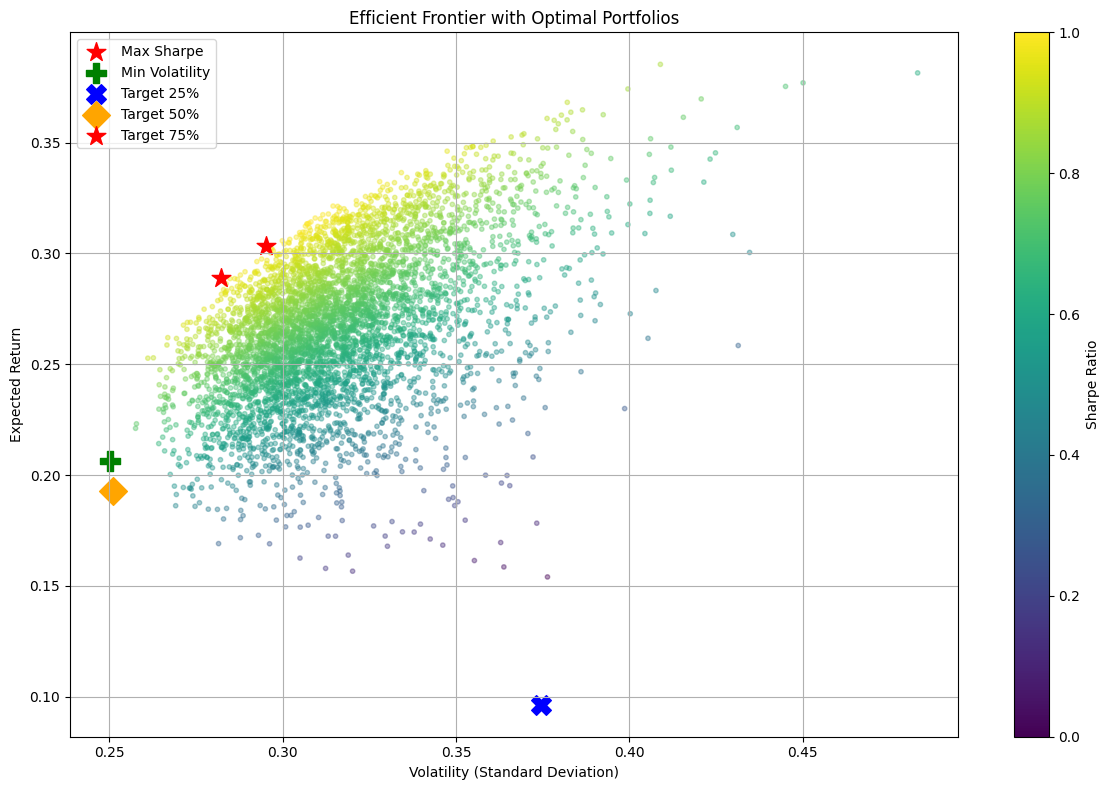


Optimal Portfolio Allocations:

Max Sharpe Portfolio:
  - Expected Annual Return : 30.34%
  - Volatility             : 29.52%
  - Sharpe Ratio           : 1.03
  - Weights:
     BABA : 0.00%
    GOOGL : 22.59%
     META : 18.95%
     MSFT : 28.81%
     OPRA : 21.71%
     PERI : 7.94%

Min Volatility Portfolio:
  - Expected Annual Return : 20.62%
  - Volatility             : 25.03%
  - Sharpe Ratio           : 0.82
  - Weights:
     BABA : 11.63%
    GOOGL : 19.96%
     META : 0.00%
     MSFT : 62.44%
     OPRA : 3.14%
     PERI : 2.83%

Target 25% Portfolio:
  - Expected Annual Return : 9.63%
  - Volatility             : 37.44%
  - Sharpe Ratio           : 0.26
  - Weights:
     BABA : 68.80%
    GOOGL : 0.00%
     META : 0.00%
     MSFT : 31.20%
     OPRA : 0.00%
     PERI : 0.00%

Target 50% Portfolio:
  - Expected Annual Return : 19.27%
  - Volatility             : 25.12%
  - Sharpe Ratio           : 0.77
  - Weights:
     BABA : 14.87%
    GOOGL : 17.93%
     META : 0.00%
     MSF

In [12]:
analyse_portfolio(['BABA', 'MSFT', 'GOOGL', 'PERI', 'META', 'OPRA'], period='5y')

Some target return portfolios may not be computed if the required return is not achievable under the given constraints or the optimisation fails to converge.